## IBM Time Series and Survival Analysis Capstone Project
### Introduction
Litecoin is a peer-to-peer Internet currency that enables instant, near-zero cost payments to anyone in the world. Litecoin is an open source, global payment network that is fully decentralized without any central authorities. Mathematics secures the network and empowers individuals to control their own finances. Litecoin features faster transaction confirmation times and improved storage efficiency than the leading math-based currency. With substantial industry support, trade volume and liquidity, Litecoin is a proven medium of commerce complementary to Bitcoin.

This notebook demonstrates the prediction of the litecoin price by the neural network model. We are using both long short term memory (LSTM) and recurrent neural network (RNN) algorithms, to find the one that suits the problem better.

### Dataset
Litecoin cryptocurrency data were retrieved from Yahoo Finance

    Date: date of observation
    Open: Opening price on the given day
    High: Highest price on the given day
    Close: Closing price on the given day
    Adjusted Close: Is the closing price after adjustments for all applicable splits and dividend distributions
    Volume: Volume of transactions on the given date

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import keras
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [3]:
Litecoin = pd.read_csv('LTC-USD.csv')
Litecoin.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,5.08589,5.17077,4.96595,5.05855,5.05855,3071840
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660
4,2014-09-21,4.26307,4.30013,4.15499,4.24592,4.24592,2931220


In [4]:
Litecoin.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2694,2022-02-01,109.589439,116.365822,108.664413,115.402000,115.402000,824048434
2695,2022-02-02,115.404503,115.882263,108.436996,108.556023,108.556023,743395485
2696,2022-02-03,108.534653,110.287003,106.417969,110.287003,110.287003,683428425
2697,2022-02-04,110.291100,120.922211,109.004990,120.918037,120.918037,953726676
2698,2022-02-05,120.735291,123.357422,119.287521,123.357422,123.357422,858523456


In [5]:
Litecoin.profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
Litecoin.isnull().values.any()

False

In [7]:
Litecoin.isnull().sum().sum()

0

In [8]:
Litecoin[Litecoin.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


In [9]:
Litecoin['Open'] = Litecoin['Open'].interpolate()
Litecoin['High'] = Litecoin['High'].interpolate()
Litecoin['Low'] = Litecoin['Low'].interpolate()
Litecoin['Close'] = Litecoin['Close'].interpolate()
Litecoin['Adj Close'] = Litecoin['Adj Close'].interpolate()
Litecoin['Volume'] = Litecoin['Volume'].interpolate()

In [10]:
Litecoin.isnull().sum().sum()

0

## Dividing the dataset into training and testing splits

In [11]:
lite_train = Litecoin[Litecoin['Date']< '2021-01-01'].copy()
lite_train

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,5.085890,5.170770,4.965950,5.058550,5.058550,3071840
1,2014-09-18,5.065430,5.065430,4.579960,4.685230,4.685230,4569260
2,2014-09-19,4.687290,4.755820,4.254350,4.327770,4.327770,3917450
3,2014-09-20,4.329200,4.616080,4.202190,4.286440,4.286440,5490660
4,2014-09-21,4.263070,4.300130,4.154990,4.245920,4.245920,2931220
...,...,...,...,...,...,...,...
2293,2020-12-27,129.456619,138.319717,123.097404,127.516968,127.516968,14103307412
2294,2020-12-28,127.588303,136.185074,127.071342,130.050339,130.050339,10248729547
2295,2020-12-29,130.033264,130.608582,121.187202,129.040802,129.040802,9160551332
2296,2020-12-30,129.061859,132.450119,123.444344,129.466080,129.466080,8127317345


In [12]:
lite_test = Litecoin[Litecoin['Date'] > '2021-01-01'].copy()
lite_test

,Date,Open,High,Low,Close,Adj Close,Volume
2299,2021-01-02,126.272964,140.372574,123.693619,136.944885,136.944885,10532067985
2300,2021-01-03,136.949402,163.898636,135.739914,160.190582,160.190582,15385661271
2301,2021-01-04,160.271164,173.027817,143.623962,154.807327,154.807327,13659785704
2302,2021-01-05,154.897552,162.850189,147.400070,158.594772,158.594772,10192818976
2303,2021-01-06,158.665970,169.657455,155.452866,169.016922,169.016922,10743884477
...,...,...,...,...,...,...,...
2694,2022-02-01,109.589439,116.365822,108.664413,115.402000,115.402000,824048434
2695,2022-02-02,115.404503,115.882263,108.436996,108.556023,108.556023,743395485
2696,2022-02-03,108.534653,110.287003,106.417969,110.287003,110.287003,683428425
2697,2022-02-04,110.291100,120.922211,109.004990,120.918037,120.918037,953726676


In [13]:
train_lt = lite_train.drop(['Date', 'Adj Close'], axis = 1)
train_lt.head()

,Open,High,Low,Close,Volume
0,5.08589,5.17077,4.96595,5.05855,3071840
1,5.06543,5.06543,4.57996,4.68523,4569260
2,4.68729,4.75582,4.25435,4.32777,3917450
3,4.32920,4.61608,4.20219,4.28644,5490660
4,4.26307,4.30013,4.15499,4.24592,2931220


In [14]:
scaler = MinMaxScaler(feature_range= (0,1))
train_lt = scaler.fit_transform(train_lt)
train_lt

array([[1.09859225e-02, 1.02314481e-02, 1.15142146e-02, 1.09232069e-02,
        1.83660073e-04],
       [1.09287671e-02, 9.94974608e-03, 1.03604946e-02, 9.87801665e-03,
        2.89838795e-04],
       [9.87242681e-03, 9.12178169e-03, 9.38724977e-03, 8.87722990e-03,
        2.43620397e-04],
       ...,
       [3.60028467e-01, 3.45679405e-01, 3.58898297e-01, 3.58038395e-01,
        6.49520161e-01],
       [3.57314831e-01, 3.50604075e-01, 3.65644870e-01, 3.59229053e-01,
        5.76255837e-01],
       [3.58483714e-01, 3.44496500e-01, 3.64425781e-01, 3.45858286e-01,
        4.44881867e-01]])

In [15]:
X_train = []
y_train = []

train_lt.shape

(2298, 5)

In [16]:
for i in range(60, train_lt.shape[0]):
    X_train.append(train_lt[i-60:i])
    y_train.append(train_lt[i,0])

In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train.shape

(2238, 60, 5)

In [19]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

## LSTM model

In [20]:
regressor = Sequential()
regressor.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor.add(Dropout(0.2))

In [21]:
regressor.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 120, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units =1))

In [22]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11200     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [23]:
import tensorflow as tf
from keras import optimizers

optimizer = tf.keras.optimizers.Adam(clipvalue=0.5)

regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [24]:
regressor.fit(X_train, y_train, epochs = 20, batch_size =32)

Epoch 1/20
70/70 [==============================] - 9s 73ms/step - loss: 0.0087
Epoch 2/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0033
Epoch 3/20
70/70 [==============================] - 5s 76ms/step - loss: 0.0027
Epoch 4/20
70/70 [==============================] - 5s 72ms/step - loss: 0.0032
Epoch 5/20
70/70 [==============================] - 5s 73ms/step - loss: 0.0025
Epoch 6/20
70/70 [==============================] - 5s 74ms/step - loss: 0.0019
Epoch 7/20
70/70 [==============================] - 5s 74ms/step - loss: 0.0020
Epoch 8/20
70/70 [==============================] - 6s 80ms/step - loss: 0.0017
Epoch 9/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0016
Epoch 10/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0018
Epoch 11/20
70/70 [==============================] - 5s 76ms/step - loss: 0.0015
Epoch 12/20
70/70 [==============================] - 5s 78ms/step - loss: 0.0013
Epoch 13/20
70/70 [==================

In [25]:
past_60_days = lite_train.tail(60)
lt= past_60_days.append(lite_test, ignore_index = True)
lt = lt.drop(['Date', 'Adj Close'], axis = 1)
lt.head()

,Open,High,Low,Close,Volume
0,55.587322,56.710835,53.205944,53.817482,3019889902
1,53.817410,54.272400,51.648445,53.819622,2580300879
2,53.819469,55.007088,51.606560,54.499104,3050534139
3,54.501873,59.223793,54.501873,58.678497,3250514599
4,58.676193,63.280354,58.465351,63.131111,4083503373


In [26]:
inputs = scaler.transform(lt)
inputs

array([[0.1520625 , 0.14806078, 0.15570304, 0.14743441, 0.21409952],
       [0.14711823, 0.14153987, 0.15104769, 0.1474404 , 0.18292924],
       [0.14712398, 0.14350459, 0.1509225 , 0.14934275, 0.21627243],
       ...,
       [0.29997174, 0.29133509, 0.31475322, 0.30553307, 0.04842623],
       [0.30487841, 0.31977595, 0.32248579, 0.33529695, 0.06759248],
       [0.33405443, 0.32628823, 0.35322017, 0.34212654, 0.06084183]])

In [27]:
X_test = []
y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])

In [28]:
X_test, y_test = np.array(X_test), np.array(y_test)
X_test.shape, y_test.shape

((400, 60, 5), (400,))

In [29]:
y_pred = regressor.predict(X_test)
y_pred, y_test

(array([[0.31667438],
        [0.31355616],
        [0.3222863 ],
        [0.34287325],
        [0.3645124 ],
        [0.38298756],
        [0.39995593],
        [0.41635582],
        [0.42828837],
        [0.4363666 ],
        [0.44158623],
        [0.43871865],
        [0.4277212 ],
        [0.41232756],
        [0.39559022],
        [0.3800239 ],
        [0.36683038],
        [0.3582987 ],
        [0.3586926 ],
        [0.3661795 ],
        [0.3742846 ],
        [0.37899408],
        [0.37809077],
        [0.37274718],
        [0.36628935],
        [0.36000285],
        [0.35382548],
        [0.3481922 ],
        [0.3466731 ],
        [0.34712836],
        [0.34624174],
        [0.34413385],
        [0.3441892 ],
        [0.3503886 ],
        [0.36074403],
        [0.37193054],
        [0.38308403],
        [0.39081648],
        [0.3975159 ],
        [0.40821677],
        [0.42697296],
        [0.44539008],
        [0.46169075],
        [0.48729014],
        [0.51367337],
        [0

In [30]:
scaler.scale_

array([2.79351645e-03, 2.67421722e-03, 2.98898933e-03, 2.79971675e-03,
       7.09077756e-11])

In [31]:
scale = 1/2.81186421e-03
scale

355.6359501442639

In [32]:
y_test = y_test*scale
y_pred = y_pred*scale

In [33]:
y_pred

array([[112.6208  ],
       [111.51185 ],
       [114.6166  ],
       [121.93806 ],
       [129.63373 ],
       [136.20415 ],
       [142.23871 ],
       [148.0711  ],
       [152.31474 ],
       [155.18765 ],
       [157.04395 ],
       [156.02412 ],
       [152.11304 ],
       [146.6385  ],
       [140.68611 ],
       [135.15016 ],
       [130.45807 ],
       [127.4239  ],
       [127.56398 ],
       [130.2266  ],
       [133.10905 ],
       [134.78392 ],
       [134.46268 ],
       [132.5623  ],
       [130.26566 ],
       [128.02995 ],
       [125.83306 ],
       [123.82966 ],
       [123.28942 ],
       [123.451324],
       [123.13601 ],
       [122.386375],
       [122.40605 ],
       [124.61078 ],
       [128.29355 ],
       [132.27187 ],
       [136.23845 ],
       [138.98839 ],
       [141.37094 ],
       [145.17656 ],
       [151.84694 ],
       [158.39673 ],
       [164.19383 ],
       [173.2979  ],
       [182.68073 ],
       [189.2995  ],
       [192.47205 ],
       [194.3

In [34]:
y_test

array([124.30330238, 134.91007531, 158.07965993, 152.74111141,
       156.48494002, 166.81931605, 167.38887817, 170.97753693,
       175.17341251, 168.83270316, 137.02675798, 130.64760512,
       145.27235903, 149.97326458, 142.10162634, 142.13803819,
       140.35952841, 150.05873322, 151.20971162, 147.81997335,
       128.07937421, 135.15674618, 135.69423099, 139.36966084,
       135.39044028, 132.72646521, 120.9933322 , 136.17091315,
       132.97265027, 131.40174594, 127.5833948 , 129.94618703,
       140.40133681, 153.49508632, 143.05779425, 152.69792307,
       153.5080621 , 148.97580289, 164.97718214, 179.65425145,
       179.72904719, 182.03828218, 194.80163573, 223.66361482,
       211.78078501, 205.1100443 , 208.04932715, 234.25741098,
       224.27303119, 233.9649896 , 224.88931445, 224.59543763,
       205.61966711, 174.66632107, 179.0561448 , 176.81397433,
       168.17362597, 169.83348504, 162.76088872, 172.92070624,
       175.66734537, 186.08288431, 178.71293996, 178.38

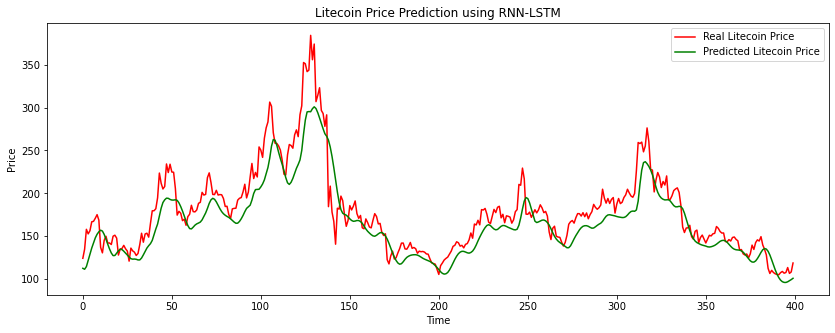

In [35]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## RNN model

In [36]:
regressor_2 = Sequential()
regressor_2.add(keras.layers.SimpleRNN(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))
regressor_2.add(Dropout(0.2))

In [37]:
regressor_2.add(keras.layers.SimpleRNN(units = 60, activation = 'relu', return_sequences = True))
regressor_2.add(Dropout(0.3))

regressor_2.add(keras.layers.SimpleRNN(units = 80, activation = 'relu', return_sequences = True))
regressor_2.add(Dropout(0.4))

regressor_2.add(keras.layers.SimpleRNN(units = 120, activation = 'relu'))
regressor_2.add(Dropout(0.5))

regressor_2.add(Dense(units =1))

In [38]:
regressor_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 60, 50)            2800      
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60, 60)            6660      
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 60, 80)            11280     
                                                                 
 dropout_6 (Dropout)         (None, 60, 80)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 120)              

In [39]:
regressor_2.compile(optimizer = optimizer, loss = 'mean_squared_error')

In [40]:
regressor_2.fit(X_train, y_train, epochs = 20, batch_size =32)

Epoch 1/20
70/70 [==============================] - 4s 30ms/step - loss: 0.0092
Epoch 2/20
70/70 [==============================] - 2s 29ms/step - loss: 0.0044
Epoch 3/20
70/70 [==============================] - 2s 27ms/step - loss: 0.0025
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.0027
Epoch 5/20
70/70 [==============================] - 2s 29ms/step - loss: 0.0028
Epoch 6/20
70/70 [==============================] - 2s 32ms/step - loss: 0.0031
Epoch 7/20
70/70 [==============================] - 2s 29ms/step - loss: 0.0021
Epoch 8/20
70/70 [==============================] - 2s 31ms/step - loss: 0.0023
Epoch 9/20
70/70 [==============================] - 2s 30ms/step - loss: 0.0022
Epoch 10/20
70/70 [==============================] - 2s 32ms/step - loss: 0.0023
Epoch 11/20
70/70 [==============================] - 2s 29ms/step - loss: 0.0020: 0s - loss: 0.00
Epoch 12/20
70/70 [==============================] - 2s 30ms/step - loss: 0.0019
Epoch 13/20
70/70 [=

In [41]:
y_pred = regressor_2.predict(X_test)

In [42]:
y_pred = y_pred*scale

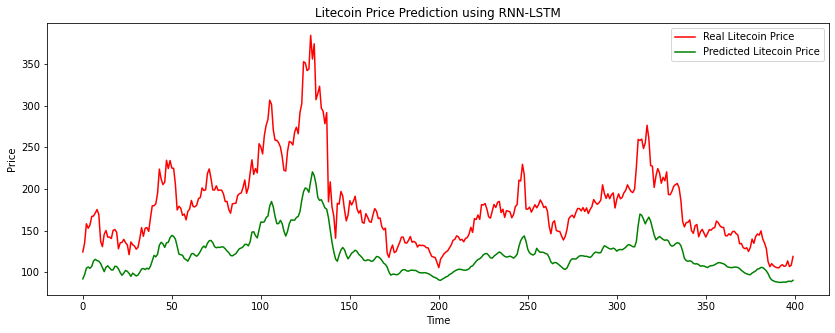

In [43]:
plt.figure(figsize=(14,5))
plt.plot(y_test, color = 'red', label = 'Real Litecoin Price')
plt.plot(y_pred, color = 'green', label = 'Predicted Litecoin Price')
plt.title('Litecoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Conclusion
In this report, two models were created for forecasting the litecoin cryptocurrency price; a Recurent neural network model and a Long Short-Term Memory model. For comparison reasons, the algorithms used the same hyperparameters and both were trained on 20 epochs.

### Results
By comparing the model summary for Simple RNN with the model summary for LSTM, it is evident that there are more trainable parameters for the LSTM (approximately 1:4 ratio for the LSTM), which explains why it took a longer time to train this model.

Overall the plots show that the LSTM model performs a lot better, compared to the RNN, as it clearly captures the upward trend of the price.

### Next Steps
To improve the quality of forecasts over many time steps, we'd need to use more data and more sophisticated LSTM model structures. We could try training with more data and running more training epochs. An additional recommendation would be to change the hyperparameters to achieve even smaller losses. However, the loss of this simple LSTM model was only 0.019.